In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
! pip install scikit-learn joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
np.random.seed(42)

root_dir = r'data\data.csv'
df = pd.read_csv(root_dir)

df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.000000,0,0.0,6,1156.500000,0.000000,0.033333,0.000000,0.0,Nov,2,2,1,20,Returning_Visitor,False,False
1,4,52.000000,1,7.0,46,3087.000000,0.003774,0.021384,16.946438,0.0,Mar,2,2,3,8,Returning_Visitor,False,True
2,4,106.500000,0,0.0,12,806.250000,0.012500,0.029167,0.000000,0.0,Dec,2,2,1,2,Returning_Visitor,False,False
3,9,497.166667,0,0.0,20,1170.166667,0.012121,0.023485,0.000000,0.0,Nov,3,2,3,2,Returning_Visitor,False,False
4,0,0.000000,0,0.0,3,17.000000,0.000000,0.033333,0.000000,0.0,Mar,1,1,1,3,Returning_Visitor,False,False


In [3]:
if df['Revenue'].dtype == bool:
    df['Revenue'] = df['Revenue'].astype(int)
if df['Weekend'].dtype == bool:
    df['Weekend'] = df['Weekend'].astype(int)

df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                      int64
Revenue                      int64
dtype: object

In [4]:
df['Total_Duration'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']
df['Total_Pages'] = df['Administrative'] + df['Informational'] + df['ProductRelated']

df['Avg_Time_Per_Page'] = df['Total_Duration'] / df['Total_Pages'].replace(0, 1)

df['Admin_Info_Ratio'] = df['Administrative'] / (df['Informational'] + 1)  # Adding 1 to avoid division by zero
df['Admin_Product_Ratio'] = df['Administrative'] / (df['ProductRelated'] + 1)
df['Info_Product_Ratio'] = df['Informational'] / (df['ProductRelated'] + 1)

df['Admin_Duration_Per_Page'] = df['Administrative_Duration'] / (df['Administrative'] + 1)
df['Info_Duration_Per_Page'] = df['Informational_Duration'] / (df['Informational'] + 1)
df['Product_Duration_Per_Page'] = df['ProductRelated_Duration'] / (df['ProductRelated'] + 1)

df['Bounce_Exit_Diff'] = df['BounceRates'] - df['ExitRates']

df[['Total_Duration', 'Total_Pages', 'Avg_Time_Per_Page', 'Admin_Info_Ratio', 
    'Admin_Product_Ratio', 'Info_Product_Ratio', 'Admin_Duration_Per_Page',
    'Info_Duration_Per_Page', 'Product_Duration_Per_Page', 'Bounce_Exit_Diff']].head()

,Total_Duration,Total_Pages,Avg_Time_Per_Page,Admin_Info_Ratio,Admin_Product_Ratio,Info_Product_Ratio,Admin_Duration_Per_Page,Info_Duration_Per_Page,Product_Duration_Per_Page,Bounce_Exit_Diff
0,1156.500000,6,192.750000,0.0,0.000000,0.000000,0.000000,0.0,165.214286,-0.033333
1,3146.000000,51,61.686275,2.0,0.085106,0.021277,10.400000,3.5,65.680851,-0.017610
2,912.750000,16,57.046875,4.0,0.307692,0.000000,21.300000,0.0,62.019231,-0.016667
3,1667.333334,29,57.494253,9.0,0.428571,0.000000,49.716667,0.0,55.722222,-0.011364
4,17.000000,3,5.666667,0.0,0.000000,0.000000,0.000000,0.0,4.250000,-0.033333


In [5]:
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df['Month_Num'] = df['Month'].map(month_map)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month_Num'].apply(get_season)

df['Holiday_Season'] = df['Month'].isin(['Nov', 'Dec']).astype(int)

df[['Month', 'Month_Num', 'Season', 'Holiday_Season']].head()

,Month,Month_Num,Season,Holiday_Season
0,Nov,11,Fall,1
1,Mar,3,Spring,0
2,Dec,12,Winter,1
3,Nov,11,Fall,1
4,Mar,3,Spring,0


In [6]:
df['Is_Returning_Visitor'] = (df['VisitorType'] == 'Returning_Visitor').astype(int)
df['Is_New_Visitor'] = (df['VisitorType'] == 'New_Visitor').astype(int)
df['Is_Other_Visitor'] = (df['VisitorType'] == 'Other').astype(int)

df[['VisitorType', 'Is_Returning_Visitor', 'Is_New_Visitor', 'Is_Other_Visitor']].head()

,VisitorType,Is_Returning_Visitor,Is_New_Visitor,Is_Other_Visitor
0,Returning_Visitor,1,0,0
1,Returning_Visitor,1,0,0
2,Returning_Visitor,1,0,0
3,Returning_Visitor,1,0,0
4,Returning_Visitor,1,0,0


In [7]:
df['PageValues_BounceRates'] = df['PageValues'] * df['BounceRates']
df['PageValues_ExitRates'] = df['PageValues'] * df['ExitRates']
df['Weekend_SpecialDay'] = df['Weekend'] * df['SpecialDay']
df['ProductRelated_Weekend'] = df['ProductRelated'] * df['Weekend']

df[['PageValues_BounceRates', 'PageValues_ExitRates', 'Weekend_SpecialDay', 'ProductRelated_Weekend']].head()

,PageValues_BounceRates,PageValues_ExitRates,Weekend_SpecialDay,ProductRelated_Weekend
0,0.000000,0.000000,0.0,0
1,0.063949,0.362377,0.0,0
2,0.000000,0.000000,0.0,0
3,0.000000,0.000000,0.0,0
4,0.000000,0.000000,0.0,0


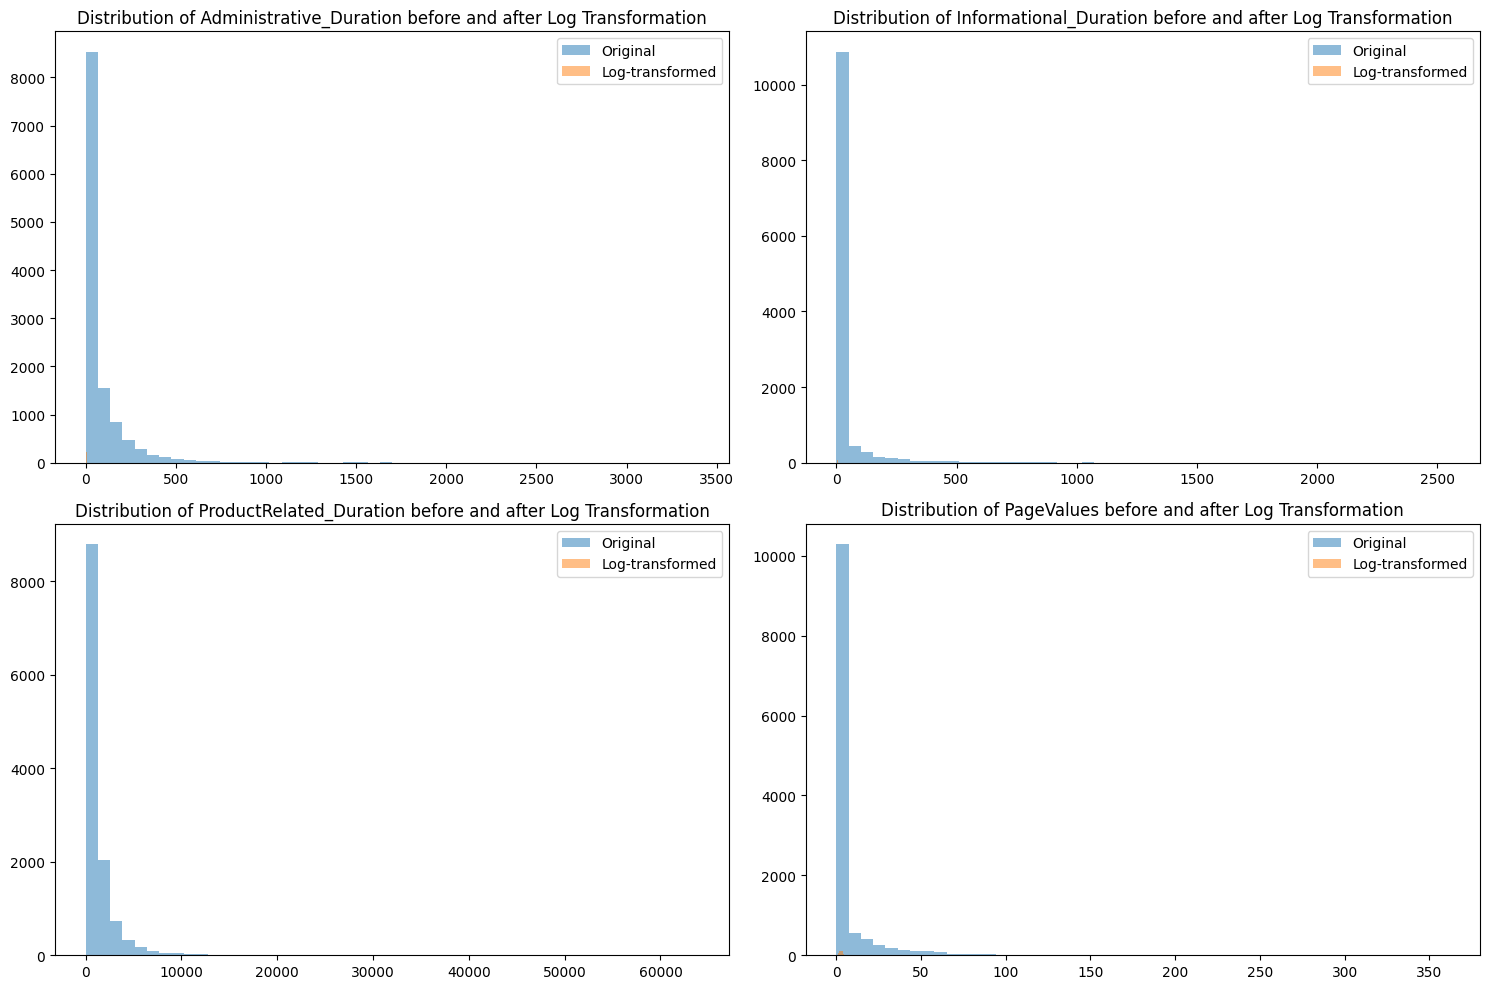

In [8]:
skewed_features = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 'PageValues']

for feature in skewed_features:
    df[f'{feature}_Log'] = np.log1p(df[feature])

plt.figure(figsize=(15, 10))
for i, feature in enumerate(skewed_features):
    plt.subplot(2, 2, i+1)
    
    plt.hist(df[feature], bins=50, alpha=0.5, label='Original')
    
    plt.hist(df[f'{feature}_Log'], bins=50, alpha=0.5, label='Log-transformed')
    
    plt.title(f'Distribution of {feature} before and after Log Transformation')
    plt.legend()

plt.tight_layout()
plt.show()

In [9]:
def create_bins(df, column, bins, labels):
    df[f'{column}_Binned'] = pd.cut(df[column], bins=bins, labels=labels)
    return df

page_value_bins = [0, 0.001, 10, 50, 100, np.inf]
page_value_labels = ['Zero', 'Low', 'Medium', 'High', 'Very High']
df = create_bins(df, 'PageValues', page_value_bins, page_value_labels)

product_related_bins = [0, 5, 20, 50, 100, np.inf]
product_related_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df = create_bins(df, 'ProductRelated', product_related_bins, product_related_labels)

df[['PageValues', 'PageValues_Binned', 'ProductRelated', 'ProductRelated_Binned']].head()

,PageValues,PageValues_Binned,ProductRelated,ProductRelated_Binned
0,0.000000,NaN,6,Low
1,16.946438,Medium,46,Medium
2,0.000000,NaN,12,Low
3,0.000000,NaN,20,Low
4,0.000000,NaN,3,Very Low


In [10]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

correlation_with_target = df[numeric_columns].corr()['Revenue'].sort_values(ascending=False)
print("Top 15 features correlated with Revenue:")
print(correlation_with_target.head(15))

correlation_matrix = df[numeric_columns].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (|correlation| > 0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} and {feat2}: {corr:.3f}")
else:
    print("\nNo feature pairs with correlation above 0.8")

Top 15 features correlated with Revenue:
Revenue                        1.000000
PageValues_Log                 0.635069
PageValues                     0.492569
PageValues_ExitRates           0.392899
ProductRelated_Duration_Log    0.200062
Administrative_Duration_Log    0.166544
Total_Pages                    0.164110
ProductRelated                 0.158538
PageValues_BounceRates         0.158110
Total_Duration                 0.156068
ProductRelated_Duration        0.152373
Administrative                 0.138917
Bounce_Exit_Diff               0.136162
Month_Num                      0.127372
Holiday_Season                 0.112932
Name: Revenue, dtype: float64

Highly correlated feature pairs (|correlation| > 0.8):
Administrative and Admin_Info_Ratio: 0.813
Administrative_Duration and Admin_Duration_Per_Page: 0.816
Informational and Informational_Duration_Log: 0.826
Informational_Duration and Info_Duration_Per_Page: 0.880
ProductRelated and ProductRelated_Duration: 0.861
ProductRelat

In [11]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 
                       'VisitorType', 'Weekend', 'Season', 'PageValues_Binned', 
                       'ProductRelated_Binned']
numerical_features = [col for col in X.columns if col not in categorical_features]

categorical_features = [col for col in categorical_features if col in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")

# Save the preprocessed data and pipeline for modeling
import joblib
joblib.dump(preprocessing_pipeline, 'models/feature_engineering_pipeline.pkl')
np.save('data/X_train_processed.npy', X_train_processed)
np.save('data/X_test_processed.npy', X_test_processed)
np.save('data/y_train.npy', y_train)
np.save('data/y_test.npy', y_test)

print("Feature engineering complete. Preprocessed data and pipeline saved.")

Processed training data shape: (9864, 111)
Processed testing data shape: (2466, 111)
Feature engineering complete. Preprocessed data and pipeline saved.


Feature ranking:
1. PageValues_Log (0.1372)
2. PageValues_ExitRates (0.1037)
3. PageValues (0.0984)
4. ExitRates (0.0340)
5. PageValues_BounceRates (0.0316)
6. Total_Duration (0.0297)
7. ProductRelated_Duration (0.0284)
8. ProductRelated_Duration_Log (0.0282)
9. Total_Pages (0.0269)
10. Bounce_Exit_Diff (0.0261)
11. ProductRelated (0.0257)
12. Avg_Time_Per_Page (0.0255)
13. Product_Duration_Per_Page (0.0241)
14. BounceRates (0.0232)
15. PageValues_Binned_Medium (0.0213)
16. Admin_Product_Ratio (0.0208)
17. Administrative_Duration_Log (0.0201)
18. Administrative_Duration (0.0188)
19. Admin_Duration_Per_Page (0.0185)
20. Admin_Info_Ratio (0.0160)


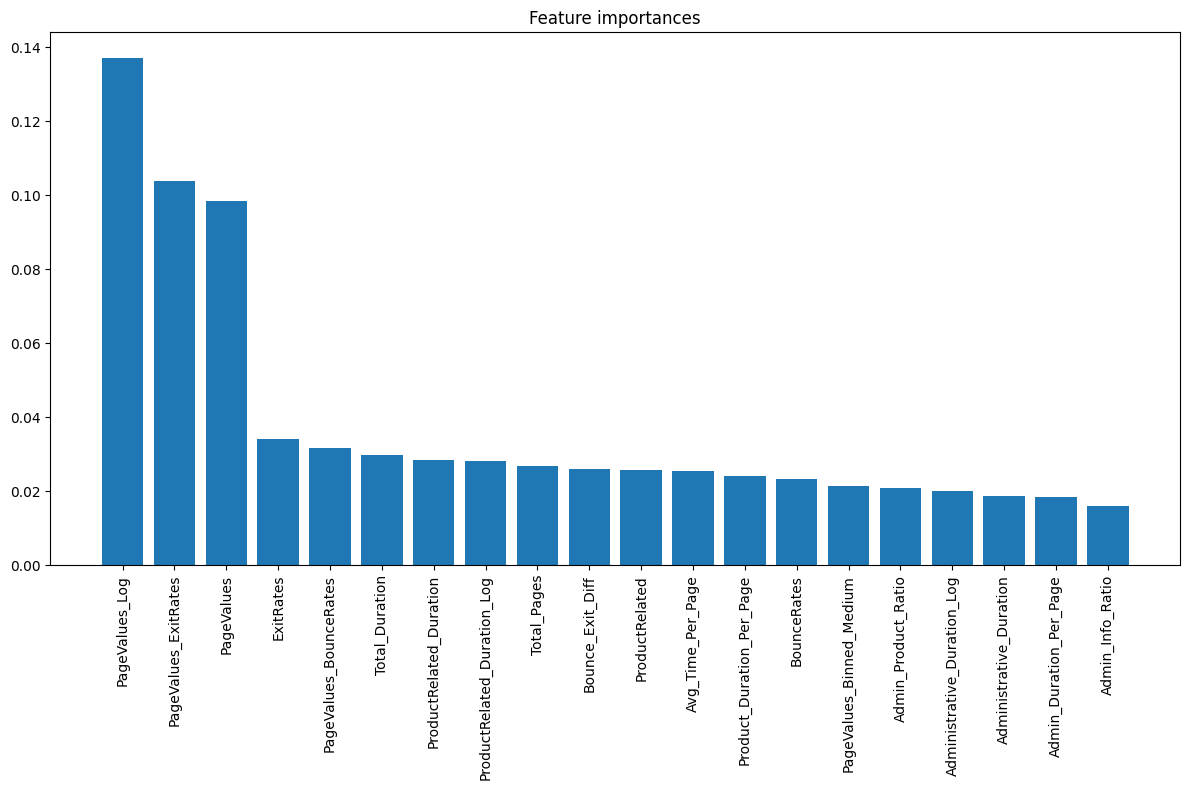

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train_processed, y_train)

try:
    feature_names = (
        numerical_features +
        preprocessing_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    )
    
    importances = model.feature_importances_
    
    indices = np.argsort(importances)[::-1]
    
    print("Feature ranking:")
    for i in range(min(20, len(feature_names))):  # Show top 20 features
        print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")
    
    plt.figure(figsize=(12, 8))
    plt.title("Feature importances")
    plt.bar(range(min(20, len(feature_names))), importances[indices[:20]], align="center")
    plt.xticks(range(min(20, len(feature_names))), [feature_names[i] for i in indices[:20]], rotation=90)
    plt.tight_layout()
    plt.show()
except:
    print("Could not extract feature names from the pipeline. Showing raw feature importance.")
    perm_importance = permutation_importance(model, X_test_processed, y_test, n_repeats=10, random_state=42)
    
    sorted_idx = perm_importance.importances_mean.argsort()[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.boxplot(perm_importance.importances[sorted_idx[:20]].T, vert=False, labels=range(1, 21))
    plt.title("Permutation Importances (top 20 features)")
    plt.tight_layout()
    plt.show()

In [13]:
import joblib
import os

os.makedirs('data/processed', exist_ok=True)
os.makedirs('data/features', exist_ok=True)
os.makedirs('models', exist_ok=True)

joblib.dump(preprocessing_pipeline, 'models/feature_engineering_pipeline.pkl')

np.save('data/processed/X_train_processed.npy', X_train_processed)
np.save('data/processed/X_test_processed.npy', X_test_processed)
np.save('data/processed/y_train.npy', y_train)
np.save('data/processed/y_test.npy', y_test)

try:
    feature_names = (
        numerical_features +
        preprocessing_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    )
    
    importances = model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    feature_importance_df.to_csv('data/features/feature_importance.csv', index=False)
    
    engineered_features = {
        'numerical_features': numerical_features,
        'categorical_features': categorical_features,
        'created_features': [
            'Total_Duration', 'Total_Pages', 'Avg_Time_Per_Page', 
            'Admin_Info_Ratio', 'Admin_Product_Ratio', 'Info_Product_Ratio',
            'Admin_Duration_Per_Page', 'Info_Duration_Per_Page', 'Product_Duration_Per_Page',
            'Bounce_Exit_Diff', 'Month_Num', 'Season', 'Holiday_Season',
            'Is_Returning_Visitor', 'Is_New_Visitor', 'Is_Other_Visitor',
            'PageValues_BounceRates', 'PageValues_ExitRates', 'Weekend_SpecialDay',
            'ProductRelated_Weekend'
        ] + [f'{feature}_Log' for feature in skewed_features]
    }
    
    import json
    with open('data/features/engineered_features.json', 'w') as f:
        json.dump(engineered_features, f, indent=4)
    
except Exception as e:
    print(f"Could not save feature names due to: {e}")

df.to_csv('data/processed/engineered_data.csv', index=False)

X_train.to_csv('data/processed/X_train.csv', index=False)
X_test.to_csv('data/processed/X_test.csv', index=False)
y_train.to_csv('data/processed/y_train_raw.csv', index=False)
y_test.to_csv('data/processed/y_test_raw.csv', index=False)

print("Feature engineering complete.")
print("- Preprocessed data saved to 'data/processed/'")
print("- Feature information saved to 'data/features/'")
print("- Preprocessing pipeline saved to 'models/'")

Feature engineering complete.
- Preprocessed data saved to 'data/processed/'
- Feature information saved to 'data/features/'
- Preprocessing pipeline saved to 'models/'
